# Deep Learning on IBM Stocks

## The Data

We choose to analyse IBM history stock data which include about 13K records from the last 54 years. [From the year 1962 to this day]
Each record contains:  
- Open price: The price in which the market in that month started at.
- Close price: The price in which the market in that month closed at.
- High Price: The max price the stock reached within the month.
- Low price: The min price the stock reached within the month.
- Volume: The max price the stock reached within the month.
- [Adjacent close price](https://marubozu.blogspot.co.il/2006/09/how-yahoo-calculates-adjusted-closing.html).  
- Date: Day, Month and Year.

The main challenges of this project are: 
- The limited data within a market that is changed by wide variety of things. In particular, things that we don't see in the raw data, like special accouncments on new technology.
- The historic data of stocks in a particular situation doesn't necessarily resolve the same outcome in the exact same situation a few years later.
- We wondered whether it is possible to actually find some features that will give us better accuracy than random.  

This project is interesting because as everybody knows deep learning solved tasks that considered difficult even with pretty basic deep learning features.  


And of course, If we find something useful when it comes to stock then good prediction = profit.

In [5]:
from pandas_datareader.data import DataReader
from datetime import datetime
import os
import pandas as pd
import random
import numpy as np
from keras.models import Sequential
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

from keras.utils.np_utils import to_categorical

Using Theano backend.


#### Load or Download the data

In [6]:
def get_data_if_not_exists(force=False):
    if os.path.exists("./data/ibm.csv") and not force:
        return pd.read_csv("./data/ibm.csv")
    else:
        if not os.path.exists("./data"):
            os.mkdir("data")
        ibm_data = DataReader('IBM', 'yahoo', datetime(1950, 1, 1), datetime.today())
        pd.DataFrame(ibm_data).to_csv("./data/ibm.csv")
        return pd.DataFrame(ibm_data).reset_index()

## Data Exploration

In [7]:
print "loading the data"
data = get_data_if_not_exists(force=True)
print "done loading the data"

loading the data
done loading the data


In [4]:
print "data columns names: %s"%data.columns.values

data columns names: ['Date' 'Open' 'High' 'Low' 'Close' 'Volume' 'Adj Close']


In [5]:
print data.shape
data.head()

(13744, 7)


,Date,Open,High,Low,Close,Volume,Adj Close
0,1962-01-02,578.499734,578.499734,572.000241,572.000241,387200,2.300695
1,1962-01-03,572.000241,576.999736,572.000241,576.999736,288000,2.320804
2,1962-01-04,576.999736,576.999736,570.999742,571.250260,256000,2.297679
3,1962-01-05,570.500243,570.500243,558.999753,560.000253,363200,2.252429
4,1962-01-08,559.500003,559.500003,545.000267,549.500263,544000,2.210196


#### Data exploration highlights:
- The data contains 13,733 records.
- Each record reprsent one specific day.
- Each record contain: Date, Open, High, Low, Close, Volume and Adj Close.

# Creating sequence of close price from the stock data

Our motivation was trying to imitiate a a stock similiar to IBM stock.

### Feature extraction:

We'll use for our features only the closing price of the stock.
And the sequence generated will include only the closing price aswell.


In [14]:
def extract_features(items):
    return [[item[4]] for item in items]

In [15]:
def extract_expected_result(item):
    return [item[4]]

In [16]:
MAX_WINDOW = 5

In [17]:
def train_test_split(data, test_size=0.1):
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))
    X, y = generate_input_and_outputs(data,extract_features,extract_expected_result)
    X_train,y_train,X_test, y_test = X[:ntrn],y[:ntrn],X[ntrn:],y[ntrn:]

    return X_train, y_train, X_test, y_test

In [18]:
def generate_input_and_outputs(data,extractFeaturesFunc=extract_features,expectedResultFunc=extract_expected_result):
    step = 1
    inputs = []
    outputs = []
    for i in range(0, len(data) - MAX_WINDOW, step):
        inputs.append(extractFeaturesFunc(data.iloc[i:i + MAX_WINDOW].as_matrix()))
        outputs.append(expectedResultFunc(data.iloc[i + MAX_WINDOW].as_matrix()))
    return inputs, outputs

In [19]:
X_train,y_train, X_test, y_test = train_test_split(data,test_size=0.15)

### Distance metrics:
For our evaluation of the quality we used several distance metrics:
* Euclidean distance.
* Squared Euclidean distance.
* Chebyshev distance.
* Cosine distance.

In [20]:
import scipy.spatial.distance as dist

def distance_functions(generated_seq):
    generated_sequence = np.asarray(generated_seq)
    original_sequence = np.asarray(y_test)

    print 'Euclidean distance: ', dist.euclidean(original_sequence, generated_sequence)
    print 'Squared Euclidean distance: ', dist.sqeuclidean(original_sequence, generated_sequence)
    print 'Chebyshev distance: ', dist.chebyshev(original_sequence, generated_sequence)
    print 'Cosine distance: ', dist.cosine(original_sequence, generated_sequence)
    return generated_sequence

def train_and_evaluate(model, model_name):
    print 'Done building'
    print 'Training...'
    model.fit(X_train, y_train, batch_size=500, nb_epoch=500, validation_split=0.15,verbose=0)
    print 'Generating sequence...'
    generated_sequence = model.predict(X_test)
    return distance_functions(generated_sequence)

### Training and Evaluation
We tried 3 different deep-learning algorithms:
* LSTM.
* GRU.
* SimpleRNN.
For each algorithm we generated a sequence, Measured its distance and plotted the given result with the original sequence.

In [21]:
layer_output_size1 = 128

print 'Building LSTM Model'
model = Sequential()
model.add(LSTM(layer_output_size1, return_sequences=False, input_shape=(MAX_WINDOW, len(X_train[0][0]))))
model.add(Dense(len(y_train[0]), input_dim=layer_output_size1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
LSTM_seq = train_and_evaluate(model, 'LSTM')
print '----------------------'

print 'Building SimpleRNN Model'
model = Sequential()
model.add(SimpleRNN(layer_output_size1, return_sequences=False, input_shape=(MAX_WINDOW, len(X_train[0][0]))))
model.add(Dense(len(y_train[0]), input_dim=layer_output_size1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
SimpleRNN_seq = train_and_evaluate(model, 'SimpleRNN')
print '----------------------'

print 'Building GRU Model'
model = Sequential()
model.add(GRU(layer_output_size1, return_sequences=False, input_shape=(MAX_WINDOW, len(X_train[0][0]))))
model.add(Dense(len(y_train[0]), input_dim=layer_output_size1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
GRU_seq = train_and_evaluate(model, 'GRU')

Building LSTM Model
Done building
Training...
Generating sequence...
Euclidean distance:  146.648831224
Squared Euclidean distance:  21505.8796994
Chebyshev distance:  22.0612487793
Cosine distance:  9.0914347589e-05
----------------------
Building SimpleRNN Model
Done building
Training...
Generating sequence...
Euclidean distance:  110.185439683
Squared Euclidean distance:  12140.8311182
Chebyshev distance:  17.1705474854
Cosine distance:  0.000102971857196
----------------------
Building GRU Model
Done building
Training...
Generating sequence...
Euclidean distance:  142.671323629
Squared Euclidean distance:  20355.1065861
Chebyshev distance:  20.6371765137
Cosine distance:  9.01642322843e-05


### Graphs showing the difference between the generated sequence and the original

#### LSTM Sequence vs Original Sequence.

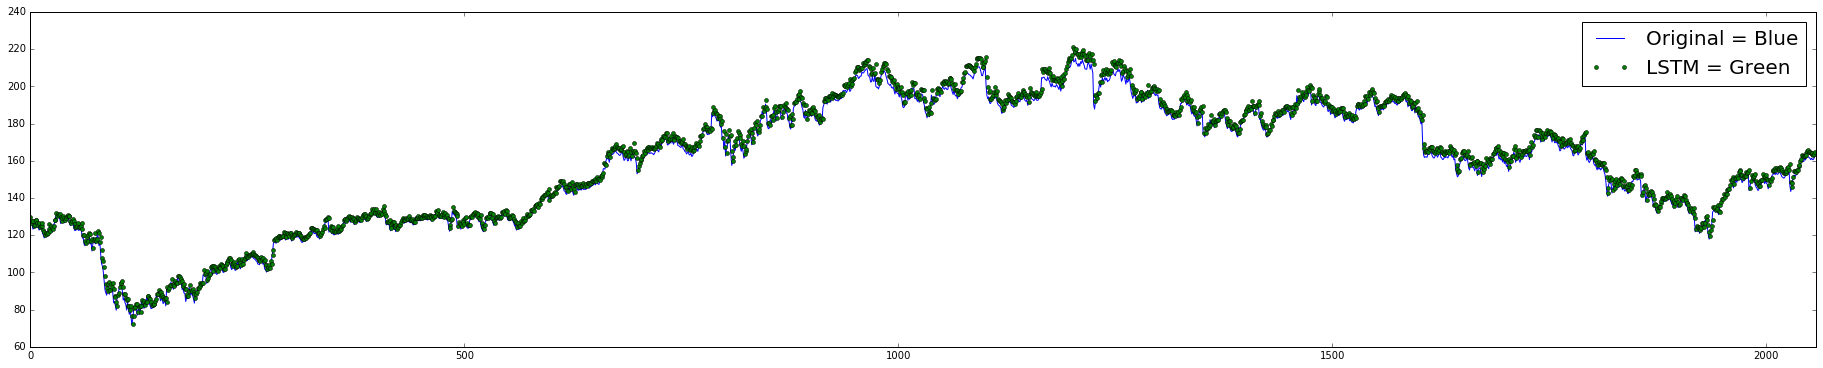

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (32, 6)
pylab.xlim([0,len(y_test)])

plt.plot(y_test, linewidth=1)
plt.plot(LSTM_seq, marker='o', markersize=4, linewidth=0)
plt.legend(['Original = Blue', 'LSTM = Green '], loc='best', prop={'size':20})
plt.show()

#### GRU Sequence vs Original Sequence

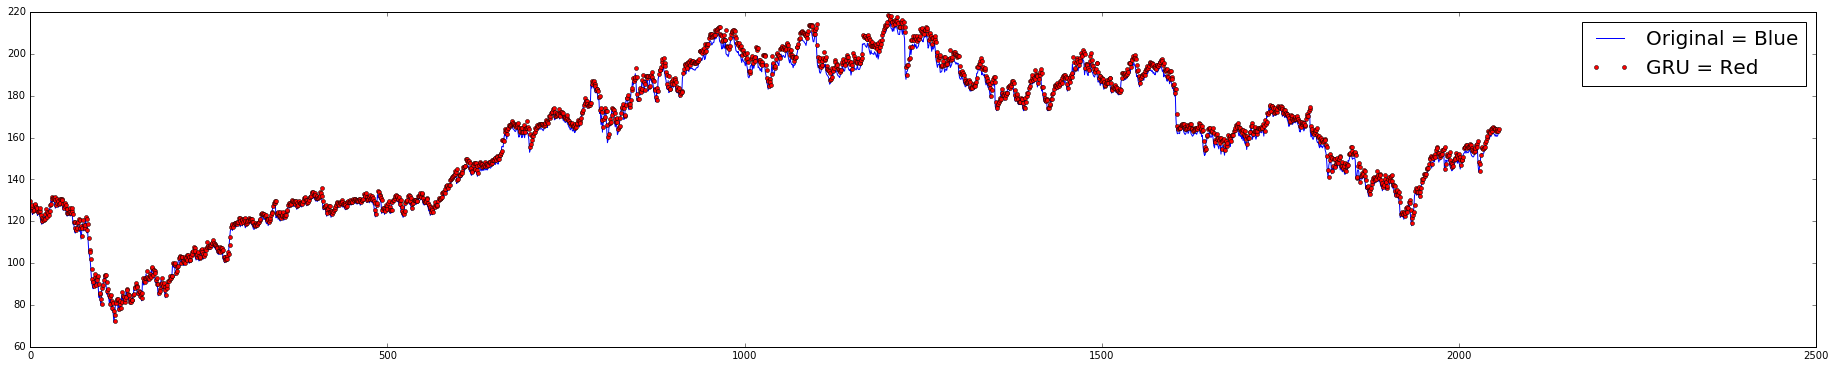

In [23]:
plt.plot(y_test, linewidth=1)
plt.plot(GRU_seq, marker='o', markersize=4, linewidth=0, c='r')
plt.legend(['Original = Blue','GRU = Red'], loc='best', prop={'size':20})
plt.show()

#### SimpleRNN Sequence vs Original Sequence.

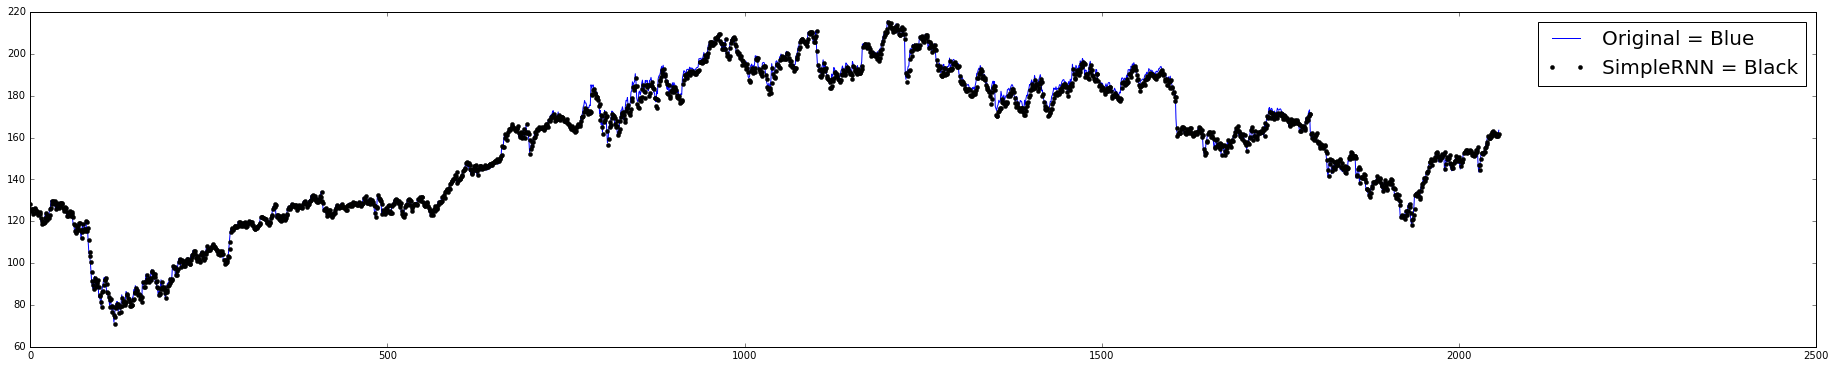

In [24]:
plt.plot(y_test, linewidth=1)
plt.plot(SimpleRNN_seq, marker='o', markersize=4, linewidth=0, c='black')
plt.legend(['Original = Blue', 'SimpleRNN = Black'], loc='best', prop={'size':20})
plt.show()

# Up / Down sequences.
After the generation of a new sequence we wanted to try another thing: Trying to predict up / down sequences.

## Feature Extraction and Data Pre-processing.

#### The features are:
1. Open price within the day.
1. Highest price within the day.
1. Lowest price within the day.
1. Close price within the day.
1. Adj Close.
1. Raise percentage.
1. Spread.
1. Up Spread.
1. Down Spread.
1. Absolute Difference between Close and Previous day close.
1. Absolute Difference between Open and Previous day open.
1. Absolute Difference between High and Previous day high.
1. Absolute Difference between low and Previous day low.
1. For each day we've also added a 7 previous day sliding window containing all of the above.
1. 1 When the stock price raised for that day, 0 When the stock price didn't raise.

In [36]:
data = get_data_if_not_exists(force=True)

for i in range(1,len(data)):
    prev = data.iloc[i-1]
    data.set_value(i,"prev_close",prev["Close"])

In [37]:
data["up/down"] = (data["Close"] - data["prev_close"]) > 0

In [38]:
data["raise_percentage"] = (data["Close"] - data["prev_close"])/data["prev_close"]

In [39]:
data["spread"] = abs(data["High"]-data["Low"])

In [40]:
data["up_spread"] = abs(data["High"]-data["Open"])

In [41]:
data["down_spread"] = abs(data["Open"]-data["Low"])

In [42]:
# import re
for i in range(1,len(data)):
    prev = data.iloc[i-1]
    data.set_value(i,"prev_open",prev["Open"])
    data.set_value(i,"prev_high",prev["High"])
    data.set_value(i,"prev_low",prev["Low"])
#     data.set_value(i,"month",re.findall("[1-9]+", str(data.Date[i]))[2])
#     data.set_value(i,"year",re.findall("[1-9]+", str(data.Date[i]))[0])
    
#     prev = data.iloc[i-2]
#     data.set_value(i,"prev_prev_open",prev["Open"])
#     data.set_value(i,"prev_prev_high",prev["High"])
#     data.set_value(i,"prev_prev_low",prev["Low"])
#     data.set_value(i,"prev_prev_close",prev["Close"])

data["close_diff"] = abs(data["Close"] - data["prev_close"])
# data["close_diff"] = data["Close"] - data["prev_close"]
# data["close_diff"] = abs(data["Close"] / data["prev_close"])
data["open_diff"] = abs(data["Open"] - data["prev_open"])
# data["open_diff"] = data["Open"] - data["prev_open"]
# data["open_diff"] = abs(data["Open"] / data["prev_open"])
data["high_diff"] = abs(data["High"] - data["prev_high"])
# data["high_diff"] = data["High"] - data["prev_high"]
# data["high_diff"] = abs(data["High"] / data["prev_high"])
data["low_diff"] = abs(data["Low"] - data["prev_low"])
# data["low_diff"] = data["Low"] - data["prev_low"]
# data["low_diff"] = abs(data["Low"] / data["prev_low"])

# data["prev_prev_close_diff"] = (data["Close"] - data["prev_prev_close"])
# data["prev_prev_raise_percentage"] = (data["Close"] - data["prev_prev_close"])/data["prev_prev_close"]
# data["prev_prev_open_diff"] = (data["Open"] - data["prev_prev_open"])
# data["prev_prev_high_diff"] = (data["High"] - data["prev_prev_high"])
# data["prev_prev_low_diff"] = (data["Low"] - data["prev_prev_low"])
# data["open_close_mean"] = (data["Open"] + data["Close"])/2

In [43]:
# removing the first record because have no previuse record therefore can't know if up or down
data = data[1:]
data.describe()

,Open,High,Low,Close,Volume,Adj Close,prev_close,raise_percentage,spread,up_spread,down_spread,prev_open,prev_high,prev_low,close_diff,open_diff,high_diff,low_diff
count,13743.000000,13743.000000,13743.000000,13743.000000,1.374300e+04,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000,13743.000000
mean,190.003999,191.599421,188.507612,190.029301,4.886859e+06,42.279857,190.059025,0.000132,3.091809,1.595423,1.496386,190.034305,191.629618,188.537477,2.015341,1.944983,1.743855,1.821356
std,132.078279,132.863132,131.408957,132.086500,4.577278e+06,51.511548,132.126487,0.019015,2.524363,1.926445,1.955096,132.119630,132.903900,131.449467,4.573759,4.469536,4.480823,4.525878
min,41.000000,41.750000,40.625000,41.000000,0.000000e+00,1.231153,41.000000,-0.749178,0.000000,0.000000,0.000000,41.000000,41.750000,40.625000,0.000000,0.000000,0.000000,0.000000
25%,97.559998,98.500000,96.500000,97.500000,1.182400e+06,5.944829,97.500000,-0.007973,1.500000,0.375000,0.270004,97.559998,98.500000,96.500000,0.500000,0.500000,0.379997,0.400002
50%,128.125000,129.250000,127.220001,128.250000,4.168000e+06,16.215748,128.250000,0.000000,2.375000,1.000000,0.875000,128.125000,129.250000,127.220001,1.180000,1.125000,1.000000,1.000000
75%,263.750046,266.000000,261.750092,263.750092,6.962550e+06,71.188760,263.812550,0.008324,3.875046,2.029999,1.999497,263.750092,266.000000,261.750092,2.499848,2.375046,2.062500,2.187500
max,649.000015,649.874802,645.500031,649.000015,6.944470e+07,197.047189,649.000015,0.131636,42.000031,28.500009,42.000031,649.000015,649.874802,645.500031,308.499985,309.000015,311.500015,312.999992


In [44]:
MAX_WINDOW = 5

In [45]:
def extract_features(items):
    return [[item[1], item[2], item[3], item[4],
            item[5], item[6], item[9], item[10],
            item[11], item[12], item[16], item[17],
            item[18], item[19], 1] 
            
            if item[8] 
            
            else 
           [item[1], item[2], item[3], item[4],
            item[5], item[6], item[9], item[10],
            item[11], item[12], item[16], item[17],
            item[18], item[19], 0] 
            
            for item in items]

def extract_expected_result(item):
    return 1 if item[8] else 0

def generate_input_and_outputs(data):
    step = 1
    inputs = []
    outputs = []
    for i in range(0, len(data) - MAX_WINDOW, step):
        inputs.append(extract_features(data.iloc[i:i + MAX_WINDOW].as_matrix()))
        outputs.append(extract_expected_result(data.iloc[i + MAX_WINDOW].as_matrix()))
    return inputs, outputs

In [46]:
print "generating model input and outputs"
X, y = generate_input_and_outputs(data)
print "done generating input and outputs"

generating model input and outputs
done generating input and outputs


In [47]:
y = to_categorical(y)

### Splitting the data to train and test

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [49]:
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=0.15)

## Configuration of the deep learning models

In [50]:
models = []

In [51]:
layer_output_size1 = 128
layer_output_size2 = 128
output_classes = len(y[0])
percentage_of_neurons_to_ignore = 0.2


model = Sequential()
model.add(LSTM(layer_output_size1, return_sequences=True, input_shape=(MAX_WINDOW, len(X[0][0]))))
model.add(Dropout(percentage_of_neurons_to_ignore))
model.add(LSTM(layer_output_size2, return_sequences=False))
model.add(Dropout(percentage_of_neurons_to_ignore))
model.add(Dense(output_classes))
model.add(Activation('softmax'))
model.alg_name = "LSTM"
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='rmsprop')
models.append(model)

model = Sequential()
model.add(SimpleRNN(layer_output_size1, return_sequences=True, input_shape=(MAX_WINDOW, len(X[0][0]))))
model.add(Dropout(percentage_of_neurons_to_ignore))
model.add(SimpleRNN(layer_output_size2, return_sequences=False))
model.add(Dropout(percentage_of_neurons_to_ignore))
model.add(Dense(output_classes))
model.add(Activation('softmax'))
model.alg_name = "SimpleRNN"
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='rmsprop')
models.append(model)

model = Sequential()
model.add(GRU(layer_output_size1, return_sequences=True, input_shape=(MAX_WINDOW, len(X[0][0]))))
model.add(Dropout(percentage_of_neurons_to_ignore))
model.add(GRU(layer_output_size2, return_sequences=False))
model.add(Dropout(percentage_of_neurons_to_ignore))
model.add(Dense(output_classes))
model.add(Activation('softmax'))
model.alg_name = "GRU"
model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='rmsprop')
models.append(model)

### Training

In [52]:
def trainModel(model):
    epochs = 5
    print "Training model %s"%(model.alg_name)
    model.fit(X_train, y_train, batch_size=128, nb_epoch=epochs,validation_data=(X_validation,y_validation), verbose=0)

### Evaluation

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

def createSplit(model):
    print 'Adding layer of DecisionTreeClassifier'
#     split_model = RandomForestClassifier()
#     split_model.fit(model.predict(X_validation), y_validation)
    
#     split_model = ExtraTreesClassifier(n_estimators=15, max_depth=None, min_samples_split=2, random_state=0)
#     split_model.fit(model.predict(X_validation), y_validation)
    
#     split_model = DecisionTreeClassifier(max_depth=None, min_samples_split=1, random_state=0)
#     split_model.fit(model.predict(X_validation), y_validation)
    
    split_model = DecisionTreeClassifier()
    split_model.fit(model.predict(X_validation), y_validation)
    return split_model

In [54]:
def probabilities_to_prediction(record):
    return [1,0] if record[0]>record[1] else [0,1]

In [55]:
def evaluateModel(model):
    success, success2 = 0,0
    predicts = model.predict(X_test)
    split_model = createSplit(model)
    for index, record in enumerate(predicts):
        predicted = list(split_model.predict([np.array(record)])[0])
        predicted2 = probabilities_to_prediction(record)
        expected = y_test[index]
        if predicted[0] == expected[0]:
            success += 1
        if predicted2[0] == expected[0]:
            success2 += 1
    accuracy = float(success) / len(predicts)
    accuracy2 = float(success2) / len(predicts)
    print "The Accuracy for %s is: %s" % (model.alg_name, max(accuracy2, accuracy, 1-accuracy, 1-accuracy2))
    return accuracy

In [56]:
def train_and_evaluate():
    accuracies = {}
    for model in models:
        trainModel(model)
        acc = evaluateModel(model)
        if model.alg_name not in accuracies:
            accuracies[model.alg_name] = []
        accuracies[model.alg_name].append(acc)
    return accuracies

In [57]:
acc = train_and_evaluate()

Training model LSTM
Adding layer of DecisionTreeClassifier
The Accuracy for LSTM is: 0.531780688986
Training model SimpleRNN
Adding layer of DecisionTreeClassifier
The Accuracy for SimpleRNN is: 0.531780688986
Training model GRU
Adding layer of DecisionTreeClassifier
The Accuracy for GRU is: 0.531780688986


### Naive algorithm:

We'll choose the most frequent up / down of the stock.

In [58]:
all_data = data["up/down"].count()
most_frequent = data["up/down"].describe().top
frequency = data["up/down"].describe().freq
acc = float(frequency) / all_data

print 'The most frequent is: %s' % (most_frequent) 
print 'The accuracy of naive algorithm is: ', acc

The most frequent is: False
The accuracy of naive algorithm is:  0.512988430474


## Summary & Evaluation analysis:

#### Evaluation process:
Our evaluation used two different configurations:
1. Raw Deep-Learning algorithm.
1. Deep-Learning algorithm With added layer of DecisionTreeClassifier.

In both cases we used the predictions of the algorithm to create a sequence to tell us whether the stock is going to get up or down. Then we checked it with the actual data and calculated accuracy.

### Results:
The accuracy as stated above is better then a naive algorithm, Not by far, But still better which means that if we follow the algorithm we are actually expected to make profit.

### What next?
As expected it seems like the raw stock data isn't get a high estimation of the stock behavior.
We could try mixing it with information from financial articles and news,  try to take into account related stocks like the sector, S&P500 and  new features,  even checking for a country specific economics laws.